In [ ]:
#establishing environment
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy
from scipy.stats import pearsonr, ttest_rel, ttest_ind
from scipy import signal as sig
import matplotlib.patches as mpatches
from scipy.io import loadmat, savemat
!pip install git+https://github.com/ieeg-portal/ieegpy.git # Install ieegpy toolbox directly from github
from ieeg.auth import Session

In [2]:
split_HUP203 = loadmat('/Users/carlosaguila/PycharmProjects/CNT_Interictal_Spikes/Results_v1/split_HUP203_phaseII.mat'); #local machine save #this is 10 gdfs
#new mat file is trimmed down amount of values. drop many of the channels and only imported the 0.5s's before and after a spike for every spike in every sequence.

In [3]:
#open the binary file and use its content to create a session frmo IEEG
with open('/Users/carlosaguila/Documents/BE521/agu_ieeglogin.bin', 'r') as f:
    session = Session('aguilac', f.read())
#get the specified dataset from IEEG
dataset = session.open_dataset('HUP203_phaseII')
chlabels = dataset.get_channel_labels()
timeseries1 = dataset.get_time_series_details(chlabels[0])
fs= timeseries1.sample_rate

In [4]:
#structure split into it's respective fields
split = split_HUP203
#fs = 512; this is the fs for HUP203, but you can just use IEEG session in cell above
chLabels = np.transpose(split['chLabels'])
values = np.transpose(split['values'])
seqs = np.transpose(split['sequences'])
leaders = np.transpose(split['leaders'])
global_coi = np.transpose(split['global_coi'])

In [5]:
#use % operator to have the same functionality as sprintf (link: https://stackoverflow.com/questions/5309978/sprintf-like-functionality-in-python )

In [6]:
#concatenates each sequence to form a GDF -- removes the sequences in each runtime
def concat_seqs(I):
    if seqs[I,0].size != 0:
        X = np.concatenate(np.concatenate(seqs[I,0]))
    else:
        X = []
    return X #recreates the GDF from which the sequence was parsed - I can be used to iterate through the whole code

In [7]:
#will apply concat_seqs to all sequenced runtimes we have in our split
seqs_concat = [];
for I in range(len(seqs)):
    seq_concat2 = concat_seqs(I)
    seqs_concat.append(seq_concat2)

In [8]:
#take the GDF/runtime --> find the max per ch 
#I refers to the index of the specific sequence runtime we want.
def max_per_runtime(seqs,values,I):
    seq_concat = concat_seqs(I);
    if len(seq_concat) != 0: #skip past the "no spike detected" sequence runtimes
        ch_uniq = np.unique(seq_concat[:,0])
        all_maxvals = []
        for ch in ch_uniq:
            x = np.where(seq_concat[:,0] == ch)[0] #should give you an array with positions where that unique ch was used.
            all_maxes_per_ch = []
            for x in x: #calls on each array in x --> (example. i == [10 34, 70] for when spike channel == 7)
                val = values[I,0][x] - np.mean(values[I,0][x])
                max_val = np.max(np.abs(val)) #FEATURE APPLICATIONS
                all_maxes_per_ch.append(max_val)
            all_maxvals.append([ch, all_maxes_per_ch]) 
    else: #the ones with spikes now
        all_maxvals = []
    return all_maxvals #will return all max values in a runtime

#take the singular max calculator from above and make it run for all sequence run_times
def maxes_for_all(seqs,values):
    all_max_vals = []
    for I in range(len(values)):
        runtime_max_vals = max_per_runtime(seqs,values,I)
        all_max_vals.append(runtime_max_vals)
    return all_max_vals

In [9]:
all_max_vals = maxes_for_all(seqs,values)
print(np.shape(all_max_vals))
print(np.shape(all_max_vals[3]))

(1049,)
(61, 2)


/Users/carlosaguila/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [10]:
print(len(chLabels[0][0]))
chlabels_idx = range(len(chLabels[0][0]))
print(chlabels_idx)
chlabels_idx = [x+1 for x in chlabels_idx] #moved to matlab indices so that it corresponds to channel numbers HAVE TO SUBTRACT ONE FOR THE PYTHON INDEX
#use np.where to then cycle through all iterations to match maxes to long list of channels vs. maxes

146
range(0, 146)


In [74]:
#print(all_max_vals[3])

In [12]:
def create_single_matrix(all_max_vals):
    new_mat = []
    for i in range(len(all_max_vals)):
       for k in range(len(all_max_vals[i])):
           a = all_max_vals[i][k]
           new_mat.append(a)
    return new_mat

def create_uniqch(all_max_vals,chlabels):
    new_mat = create_single_matrix(all_max_vals)
    ch_id = range(len(chLabels[0][0]))
    ch_id = (x+1 for x in ch_id)
    total_maxes = []
    total_maxes_fin = []
    for ch in ch_id:
        ch_maxes = []
        for i in range(len(new_mat)):
            if new_mat[i][0] == ch:
                x = new_mat[i][1]
                ch_maxes.append(x)
        total_maxes.append(ch_maxes)
        
    for chX in total_maxes:
        if len(chX) != 0:
            x = np.concatenate(chX)
            total_maxes_fin.append(x)
        else:
            total_maxes_fin.append([])
        
    return total_maxes_fin

In [13]:
total_maxes = create_uniqch(all_max_vals,chLabels)

In [75]:
total_maxes2 = [np.mean(x) for x in total_maxes]
#print(total_maxes2)

/Users/carlosaguila/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/carlosaguila/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


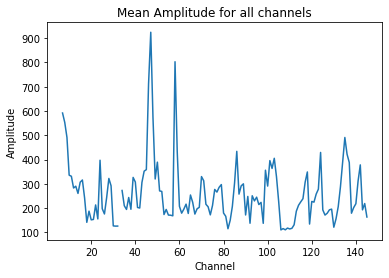

In [15]:
chlabels_idx = range(len(chLabels[0][0]))
chlabels_idx = [x+1 for x in chlabels_idx]
plt.plot(chlabels_idx,total_maxes2)
plt.title('Mean Amplitude for all channels')
plt.xlabel('Channel')
plt.ylabel('Amplitude')
plt.show()

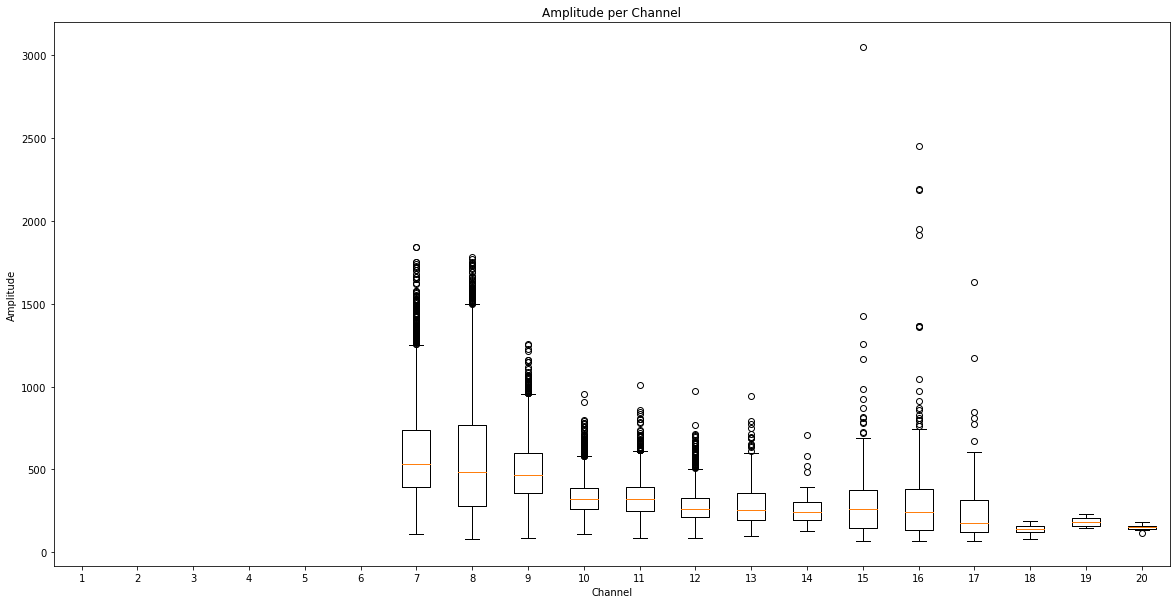

In [16]:
plt.figure(figsize=(20,10))
chlabels_idx = range(len(chLabels[0][0]))
chlabels_idx = [x+1 for x in chlabels_idx]
plt.boxplot(total_maxes[0:20],positions=chlabels_idx[0:20]);
plt.title('Amplitude per Channel')
plt.xlabel('Channel')
plt.ylabel('Amplitude')
plt.show()

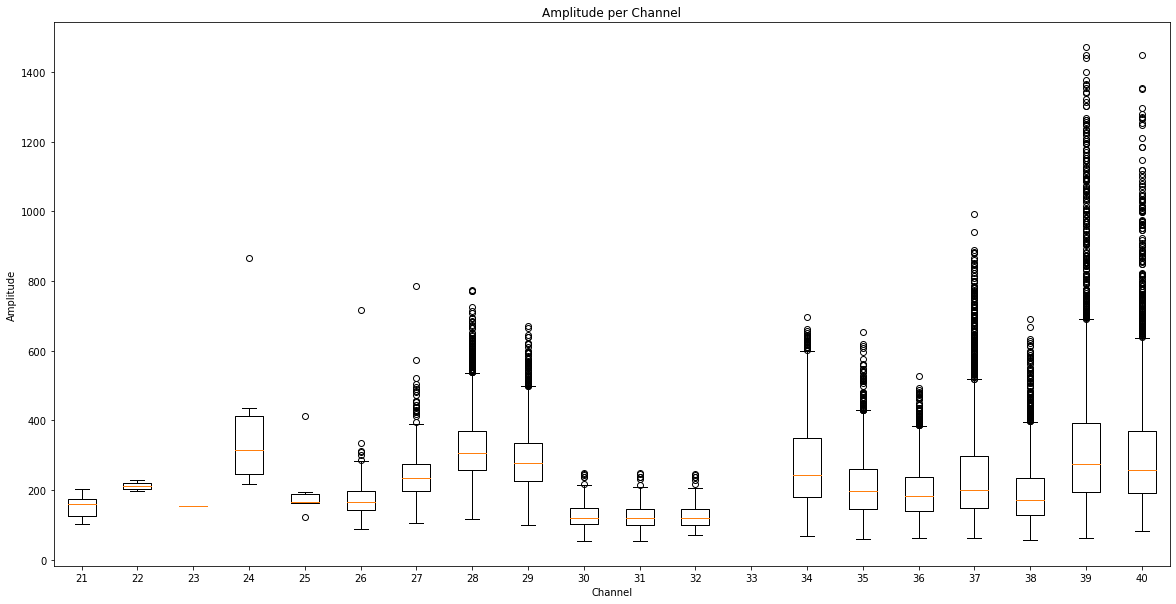

In [17]:
plt.figure(figsize=(20,10))
chlabels_idx = range(len(chLabels[0][0]))
chlabels_idx = [x+1 for x in chlabels_idx]
plt.boxplot(total_maxes[20:40],positions=chlabels_idx[20:40]);
plt.title('Amplitude per Channel')
plt.xlabel('Channel')
plt.ylabel('Amplitude')
plt.show()

---

So now with all_max_vals, we have all the max values for each instance of a spike for all channels that were deemed to be in a sequence, in each run time.
- since analysis will be on the more macro scale - the sequences were split
    - Perhaps you can find the sequence things are a part of by calling on the original seqs and finding lengths.

max_per_runtime - First code finds the max value at each channel in a given runtime
maxes_for_all - expands max_per_runtime to every runtime in the split.


Notes:
- Each channel was baselined by its own mean *not excluding the spike* such that you get a p2 - b2, p2 - b2, ...
    - This allows us to get the absolute max value in each epoch.

---

Next step:
filter out channels that could potentially be artifact - maybe if they have less then 2-3 pings then maybe they are artifact (this will have to take into account all runtimes)
running a statistical test to find out if the SOZ channels have a larger max value than those that arent SOZ channels - this will probably look like a paired t-test type of deal

Think of Plots:
- graph that shows SOZ vs nonSOZ channels and their 1 feature across patients. 
    - Average SOZ max per channel---- seperated into SOZ vs. nonSOZ channels. plot those.
    - Find a statistic based on that^^^^
    
 
QUESTIONS:
   - AES
   - HUP 119 - has no 'data' field - ask if i can just skip that one -- can be skipped
  
   

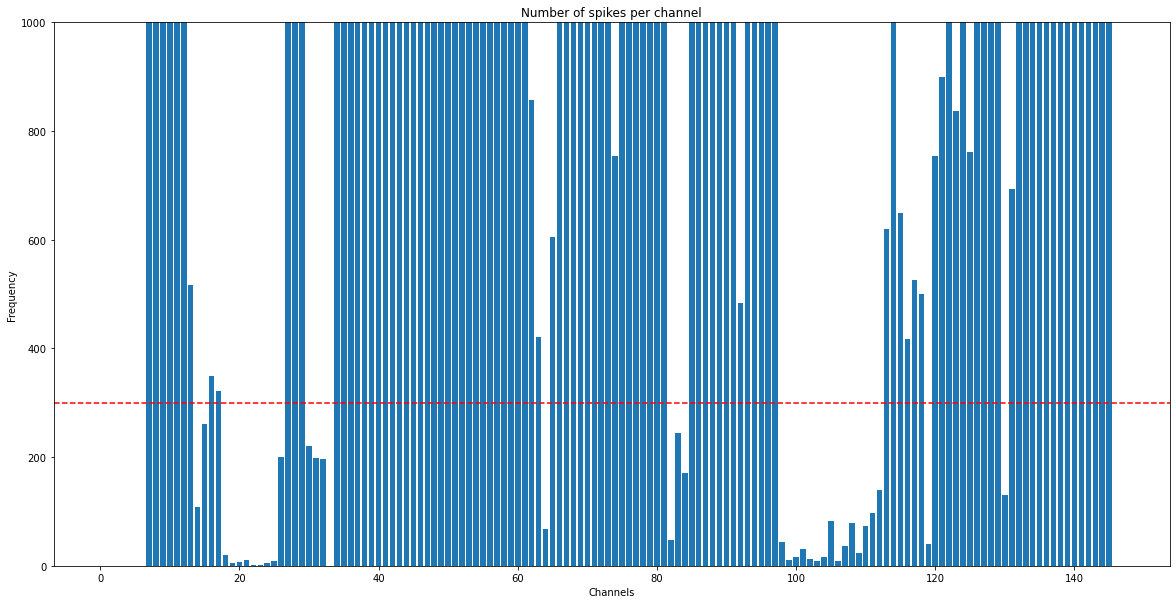

In [18]:
#filter the channels that have low numbers of instances (would imply that instances are artifacts)

#create histogram to choose arbitrary threshold:
cumul_list = []
for maxes in total_maxes:
    cumul_list.append(len(maxes))

x = np.arange(1,147)
plt.figure(figsize=(20,10))
plt.bar(x,cumul_list)
plt.title('Number of spikes per channel')
plt.xlabel('Channels')
plt.ylabel('Frequency')
plt.ylim([0,1000])
plt.axhline(y=300,linestyle='dashed',color='r')
plt.show()

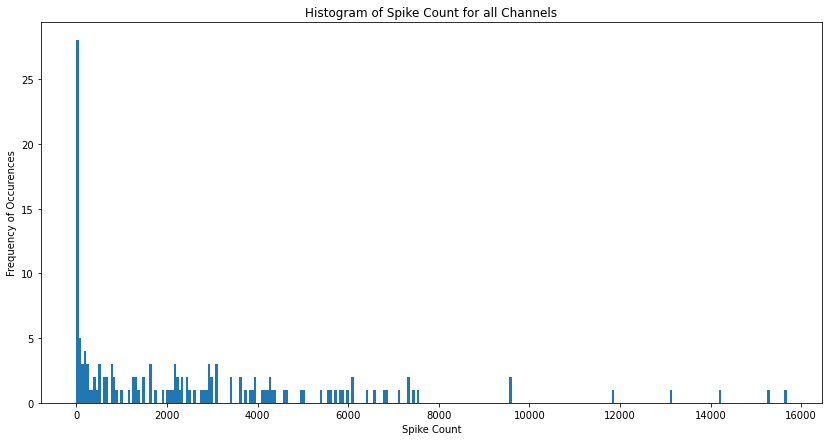

In [19]:
#print(cumul_list)

plt.figure(figsize=(14,7))
_,bins,_ = plt.hist(cumul_list,bins=2*146)
plt.title('Histogram of Spike Count for all Channels')
plt.xlabel('Spike Count')
plt.ylabel('Frequency of Occurences')
plt.show()

#print(bins)

The histogram and barplot shows that there are about 30 channels with less than 100 spikes. It might be possible to filter out these low activity channels.

---

In [101]:
def filter_ch(total_maxes):
    #create a cumulative list that tracks the amount of spikes in each channel
    cumul_list = []
    for maxes in total_maxes:
        cumul_list.append(len(maxes))
    #create a histogram, use the edge of first bin as the cutoff
    _,bins,_ = plt.hist(cumul_list,bins=2*146)
    plt.close()
    filt_maxes = []
    for ch in total_maxes:
        if len(ch) <= bins[1]: #uses the cutoff to threshold what we consider artifacts in a channel
            filt_maxes.append([]);
        else:
            filt_maxes.append(ch)
    return filt_maxes #new total_maxes matrix with no deemed low activity channels

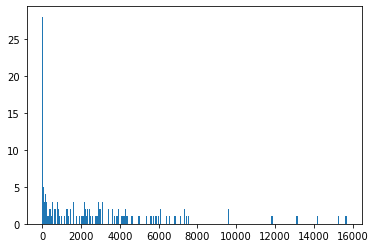

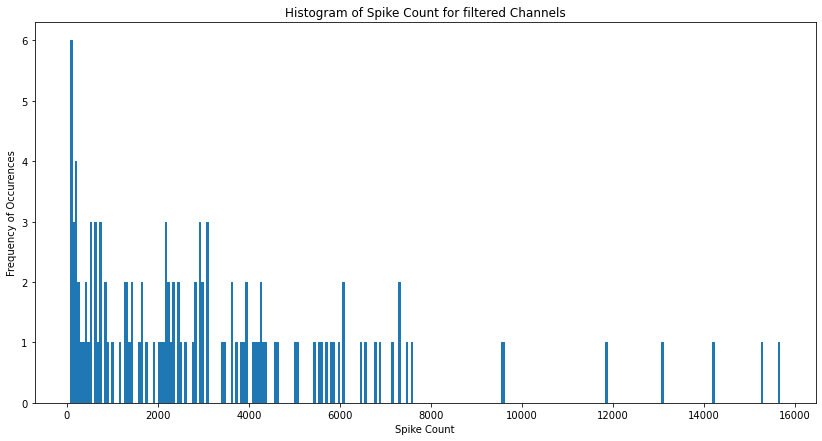

In [21]:
filt_maxes = filter_ch(total_maxes)
cumul_filt_list = []

for maxes in filt_maxes:
    if len(maxes) != 0:
        cumul_filt_list.append(len(maxes))

plt.figure(figsize=(14,7))
_,bins,_ = plt.hist(cumul_filt_list,bins=2*146)
plt.title('Histogram of Spike Count for filtered Channels')
plt.xlabel('Spike Count')
plt.ylabel('Frequency of Occurences')
plt.show()

---

In [22]:
#Now we will create lists of the SOZ for each pt

SOZ_chlabels = pd.read_csv("/Users/carlosaguila/PycharmProjects/CNT_Interictal_Spikes/SOZ_channels.csv")

In [23]:
print(SOZ_chlabels)

                                         SOZ electrode
0                                                  NaN
1    LPF2, LPF3, ROF7, ROF8, APD1, APD2, APD3, APD4...
2                 LF3, LF4, LF5, LF6, LDH1, LDH2, LDH3
3                       RDNET1, RDNET2, RDNET3, RDNET4
4                                            LH2, LAT2
..                                                 ...
114                                 RB2, RB3, RC2, RC3
115                       RA7, RB1, RB2, RB3, RC2, RA2
116                                           LB3, LC3
117  LB1, LB2, LB3, LB4, LB5, LC1, LC2, LC3, LC4, R...
118                  RB1, RB2, RB3, RB4, RT4, RT5, RT6

[119 rows x 1 columns]


In [24]:
#patient SOZ channels loaded via whichPts-1 indexing and then changed to match ChLabels structure
def prep_chlabels(WhichPts):
    hup203_soz = (SOZ_chlabels.iloc[WhichPts])
    hup203_soz = [x for x in hup203_soz]
    hup203_soz = hup203_soz[0].replace(" ","")
    hup203_soz = hup203_soz.split(',')
    hup203_soz = [x+'-CAR' for x in hup203_soz]
    return hup203_soz

In [25]:
hup203_soz = (SOZ_chlabels.iloc[98])
hup203_soz = [x for x in hup203_soz]
hup203_soz = hup203_soz[0].replace(" ","")
hup203_soz = hup203_soz.split(',')
hup203_soz = [x+'-CAR' for x in hup203_soz]

In [26]:
print(hup203_soz)
print(prep_chlabels(98))

['LA1-CAR', 'LA2-CAR', 'LA3-CAR', 'LA4-CAR', 'LB5-CAR', 'LB6-CAR', 'RB9-CAR', 'RB10-CAR', 'RB11-CAR', 'RE9-CAR', 'RE10-CAR', 'RE11-CAR', 'RF9-CAR', 'RF10-CAR', 'RF11-CAR', 'RG9-CAR', 'RG10-CAR', 'RG11-CAR', 'RB1-CAR', 'RB2-CAR', 'RC1-CAR', 'RC3-CAR']
['LA1-CAR', 'LA2-CAR', 'LA3-CAR', 'LA4-CAR', 'LB5-CAR', 'LB6-CAR', 'RB9-CAR', 'RB10-CAR', 'RB11-CAR', 'RE9-CAR', 'RE10-CAR', 'RE11-CAR', 'RF9-CAR', 'RF10-CAR', 'RF11-CAR', 'RG9-CAR', 'RG10-CAR', 'RG11-CAR', 'RB1-CAR', 'RB2-CAR', 'RC1-CAR', 'RC3-CAR']


In [27]:
SOZ_find = []
for i in range(len(hup203_soz)):
    find = np.where(hup203_soz[i] == chLabels[0][0])[0]
    SOZ_find.append(find)
    
SOZ_find = np.concatenate(SOZ_find) #return python index of SOZ matched

SOZ_find2 = [x+1 for x in SOZ_find] #returns matlab index of SOZ matched

print(SOZ_find) #first channel starts at 0
print(SOZ_find2) #first channel starts at 1

[ 6  7  8  9 21 22 53 54 55 45 46 57 59]
[7, 8, 9, 10, 22, 23, 54, 55, 56, 46, 47, 58, 60]


In [28]:
SOZ_maxes = []
for soz_ch in SOZ_find:
    SOZ_maxes.append(filt_maxes[soz_ch])

In [29]:
print(len(SOZ_maxes[-7]))

5729


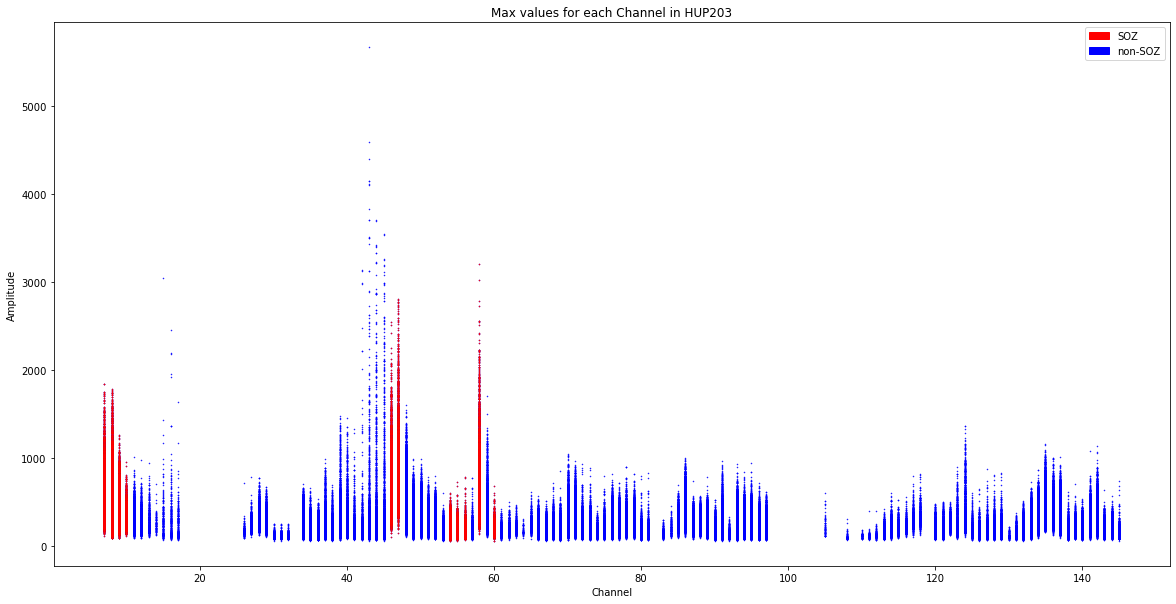

In [96]:
import matplotlib.patches as mpatches
label_idx = np.arange(1,147)

plt.figure(figsize=(20,10))
for x, y in zip(label_idx,filt_maxes):
    plt.scatter([x]*len(y), y, color='b',marker=".", s=1)
    
for xe, ye in zip(SOZ_find2, SOZ_maxes):
    plt.scatter([xe] * len(ye), ye,color='r',marker=".", s=1)

plt.title('Max values for each Channel in HUP203')
SOZ_label = mpatches.Patch(color='r', label='SOZ') #imported matplotlib.patches -> manually creates legend since auto-detection of the legend via plt.legend() didn't work
nonSOZ_label = mpatches.Patch(color='b', label='non-SOZ')
plt.legend(handles=[SOZ_label,nonSOZ_label])
plt.ylabel('Amplitude')
plt.xlabel('Channel')
plt.show()

In [31]:
#clear SOZ channels from the filtered total maxes list

SOZ_find #SOZ labels
SOZ_maxes #just SOZ max values

all_ch = range(len(chLabels[0][0])) #all labels
filt_maxes #all 

nonSOZ_idx = [label for label in all_ch if label not in SOZ_find]
nonSOZ_maxes = []

for soz_ch in nonSOZ_idx:
    nonSOZ_maxes.append(filt_maxes[soz_ch])

In [32]:
nonSOZ_all = np.concatenate(nonSOZ_maxes)
SOZ_all = np.concatenate(SOZ_maxes)

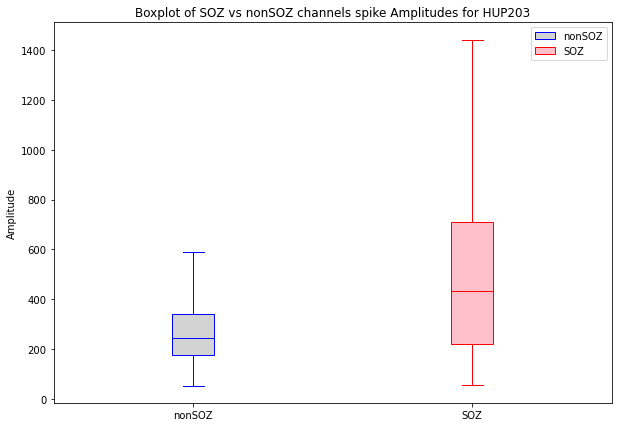

In [33]:
def box_plot(data, positions, edge_color, fill_color):
    bp = plt.boxplot(data,positions=positions, patch_artist=True,showfliers=False)
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       
        
    return bp

plt.figure(figsize=(10,7))
bp1 = box_plot(nonSOZ_all, [1], 'blue', 'lightgrey')
bp2 = box_plot(SOZ_all, [2], 'red', 'pink')
plt.legend([bp1["boxes"][0], bp2["boxes"][0]], ['nonSOZ', 'SOZ'])
plt.xticks([1, 2], ['nonSOZ', 'SOZ'])
plt.title('Boxplot of SOZ vs nonSOZ channels spike Amplitudes for HUP203')
plt.ylabel('Amplitude')
plt.show()

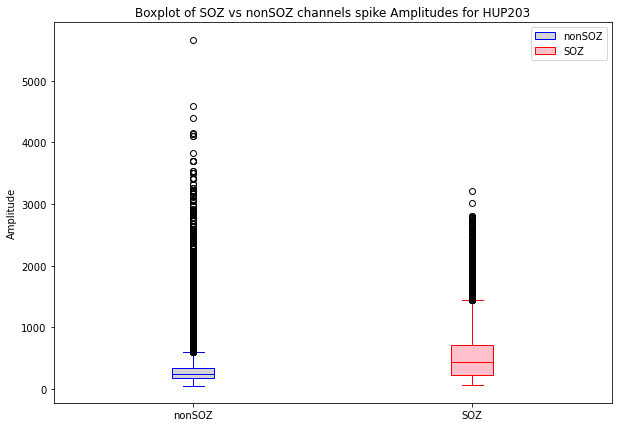

In [34]:
def box_plot_outliers(data, positions, edge_color, fill_color):
    bp = plt.boxplot(data,positions=positions, patch_artist=True,showfliers=True)
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       
        
    return bp

plt.figure(figsize=(10,7))
bp1 = box_plot_outliers(nonSOZ_all, [1], 'blue', 'lightgrey')
bp2 = box_plot_outliers(SOZ_all, [2], 'red', 'pink')
plt.legend([bp1["boxes"][0], bp2["boxes"][0]], ['nonSOZ', 'SOZ'])
plt.xticks([1, 2], ['nonSOZ', 'SOZ'])
plt.title('Boxplot of SOZ vs nonSOZ channels spike Amplitudes for HUP203')
plt.ylabel('Amplitude')
plt.show()

In [43]:
stats, pval = ttest_ind(nonSOZ_all, SOZ_all, equal_var = False)
print(ttest_ind(nonSOZ_all, SOZ_all, equal_var = False))

#perform an independent two sample t test with UNEQUAL variances (as seen on box plot)
#essentially performed a welch's t test. 

#shows that the average amplitude significantly greater in the spikes found in the SOZ.

Ttest_indResult(statistic=-138.0318686361873, pvalue=0.0)


In [42]:
print(stats)
print(pval)

-138.0318686361873
0.0


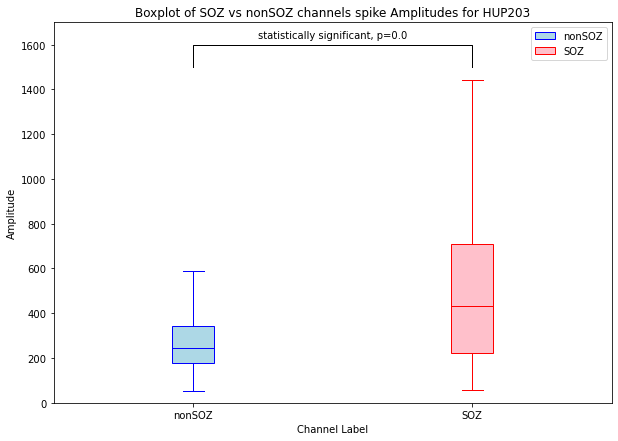

In [79]:
def box_plot(data, positions, edge_color, fill_color):
    bp = plt.boxplot(data,positions=positions, patch_artist=True,showfliers=False)
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       
        
    return bp

plt.figure(figsize=(10,7))
bp1 = box_plot(nonSOZ_all, [1], 'blue', 'lightblue')
bp2 = box_plot(SOZ_all, [2], 'red', 'pink')
plt.legend([bp1["boxes"][0], bp2["boxes"][0]], ['nonSOZ', 'SOZ'])
plt.xticks([1, 2], ['nonSOZ', 'SOZ'])
plt.title('Boxplot of SOZ vs nonSOZ channels spike Amplitudes for HUP203')
plt.ylabel('Amplitude')

x1 = 1;
x2 = 2;
y1 = 1500;
y2 = 1600;
y3 = 1900
plt.plot([x1,x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='k')
plt.text(3/2,1620, 'statistically significant, p=0.0', ha='center', va='bottom', color='k')
plt.ylim([0,1700])
plt.xlabel('Channel Label')
plt.show()

---

In [104]:
#full pipeline in 1 function
def load_split(filename):
    pathway = '/Users/carlosaguila/PycharmProjects/CNT_Interictal_Spikes/Results_v1/split_'
    filetype = '.mat'
    split = loadmat(pathway+filename+filetype);
    chLabels = np.transpose(split['chLabels'])
    values = np.transpose(split['values'])
    seqs = np.transpose(split['sequences'])
    leaders = np.transpose(split['leaders'])
    global_coi = np.transpose(split['global_coi'])
    return split, chLabels, values, seqs #global_coi, leaders #you can comment in the global_coi and leaders if need be.

def calc_maxes_and_stats(filename, WhichPts):
    split, chLabels, values, seqs = load_split(filename)
    
    all_max_vals = maxes_for_all(seqs,values)
    total_maxes = create_uniqch(all_max_vals,chLabels)
    filt_maxes = filter_ch(total_maxes)
    
    SOZ_chlabels = pd.read_csv("/Users/carlosaguila/PycharmProjects/CNT_Interictal_Spikes/pt_data/SOZ_channels.csv")
    hup_soz = prep_chlabels(WhichPts)
    SOZ_find = []
    for i in range(len(hup_soz)):
        find = np.where(hup_soz[i] == chLabels[0][0])[0]
        SOZ_find.append(find)

    SOZ_find = np.concatenate(SOZ_find) #return python index of SOZ matched

    SOZ_find2 = [x+1 for x in SOZ_find]
    SOZ_maxes = []
    for soz_ch in SOZ_find:
        SOZ_maxes.append(filt_maxes[soz_ch])

    all_ch = range(len(chLabels[0][0])) #all labels

    nonSOZ_idx = [label for label in all_ch if label not in SOZ_find]
    nonSOZ_maxes = []
    for soz_ch in nonSOZ_idx:
        nonSOZ_maxes.append(filt_maxes[soz_ch])

    nonSOZ_all = np.concatenate(nonSOZ_maxes)
    SOZ_all = np.concatenate(SOZ_maxes)
    
    stats, pval = ttest_ind(nonSOZ_all, SOZ_all, equal_var = False)

    return pval, SOZ_all, nonSOZ_all

def maxes_for_plot(filename, WhichPts):
    split, chLabels, values, seqs = load_split(filename)
    
    all_max_vals = maxes_for_all(seqs,values)
    total_maxes = create_uniqch(all_max_vals,chLabels)
    filt_maxes = filter_ch(total_maxes)
    
    SOZ_chlabels = pd.read_csv("/Users/carlosaguila/PycharmProjects/CNT_Interictal_Spikes/pt_data/SOZ_channels.csv")
    hup_soz = prep_chlabels(WhichPts)
    SOZ_find = []
    for i in range(len(hup_soz)):
        find = np.where(hup_soz[i] == chLabels[0][0])[0]
        SOZ_find.append(find)

    SOZ_find = np.concatenate(SOZ_find) #return python index of SOZ matched

    SOZ_find2 = [x+1 for x in SOZ_find]
    SOZ_maxes = []
    for soz_ch in SOZ_find:
        SOZ_maxes.append(filt_maxes[soz_ch])

    all_ch = range(len(chLabels[0][0])) #all labels

    nonSOZ_idx = [label for label in all_ch if label not in SOZ_find]
    nonSOZ_maxes = []
    for soz_ch in nonSOZ_idx:
        nonSOZ_maxes.append(filt_maxes[soz_ch])

    nonSOZ_all = np.concatenate(nonSOZ_maxes)
    SOZ_all = np.concatenate(SOZ_maxes)
    
    stats, pval = ttest_ind(nonSOZ_all, SOZ_all, equal_var = False)
    return filt_maxes, total_maxes, SOZ_find2, SOZ_maxes, nonSOZ_all, SOZ_all, pval

def plot_scatter(filename, WhichPts):
    
    filt_maxes, total_maxes, SOZ_find2, SOZ_maxes, nonSOZ_all, SOZ_all, pval = maxes_for_plot(filename, WhichPts)
    
    label_idx = np.arange(1,147)
    plt.figure(figsize=(20,10))
    for x, y in zip(label_idx,filt_maxes):
        plt.scatter([x]*len(y), y, color='b',marker=".", s=1)

    for xe, ye in zip(SOZ_find2, SOZ_maxes):
        plt.scatter([xe] * len(ye), ye,color='r',marker=".", s=1)

    plt.title('Max values for each Channel in '+filename)
    SOZ_label = mpatches.Patch(color='r', label='SOZ') #imported matplotlib.patches -> manually creates legend since auto-detection of the legend via plt.legend() didn't work
    nonSOZ_label = mpatches.Patch(color='b', label='non-SOZ')
    plt.legend(handles=[SOZ_label,nonSOZ_label])
    plt.ylabel('Amplitude')
    plt.xlabel('Channel')
    plt.show()
    return 
    
def plot_box_per_pt(filename, WhichPts):
    filt_maxes, total_maxes, SOZ_find2, SOZ_maxes, nonSOZ_all, SOZ_all, pval = maxes_for_plot(filename, WhichPts)

    plt.figure(figsize=(10,7))
    bp1 = box_plot(nonSOZ_all, [1], 'blue', 'lightblue')
    bp2 = box_plot(SOZ_all, [2], 'red', 'pink')
    plt.legend([bp1["boxes"][0], bp2["boxes"][0]], ['nonSOZ', 'SOZ'])
    plt.xticks([1, 2], ['nonSOZ', 'SOZ'])
    plt.title('Boxplot of SOZ vs nonSOZ channels spike Amplitudes for '+filename)
    plt.ylabel('Amplitude')

    x1 = 1
    x2 = 2
    y1 = 1500
    y2 = 1600
    y3 = 1900
    plt.plot([x1,x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='k')
    stat_string = 'statistically significant, p='
    pval_string = stat_string+str(pval)
    plt.text(3/2,1620, s=pval_string, ha='center', va='bottom', color='k')
    plt.ylim([0,1700])
    plt.xlabel('Channel Label')
    plt.show()

    return

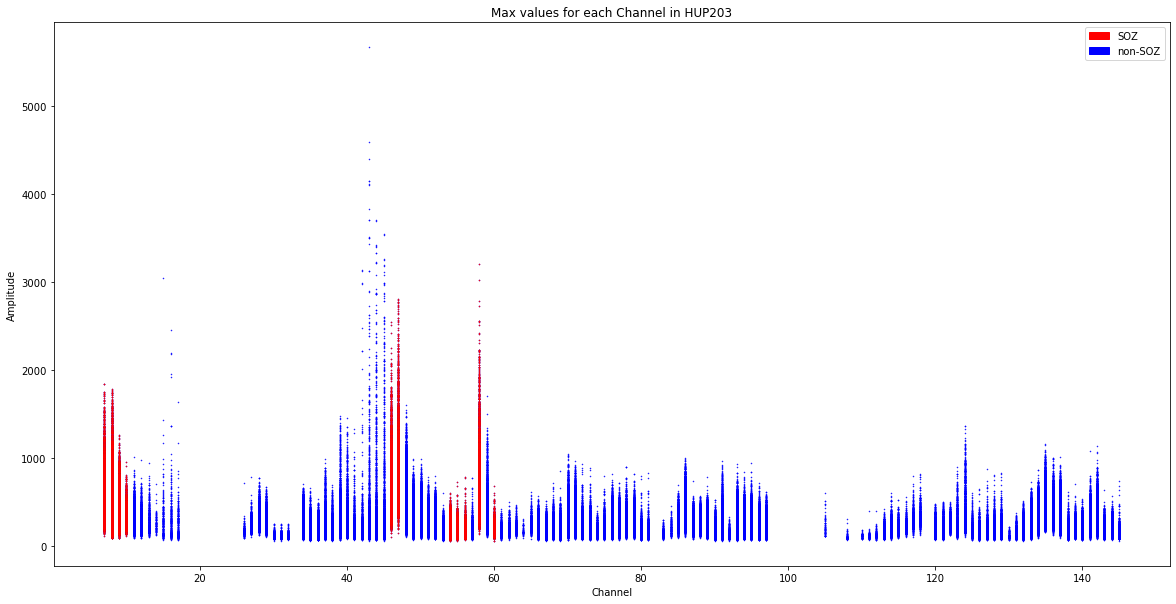

In [102]:
plot_scatter('HUP203_phaseII',98)

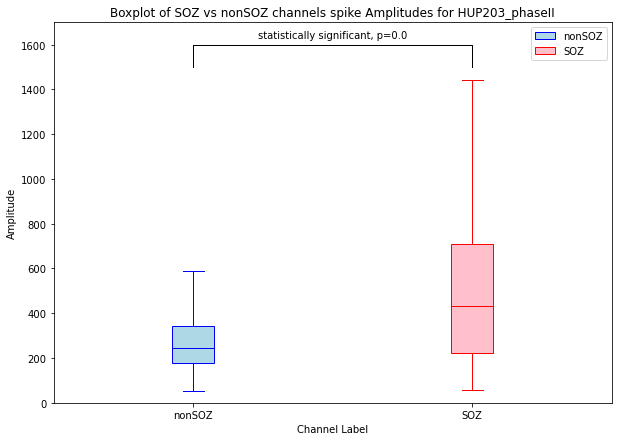

In [103]:
plot_box_per_pt('HUP203_phaseII',98)

pvalue for HUP203_phaseII  = 0.0


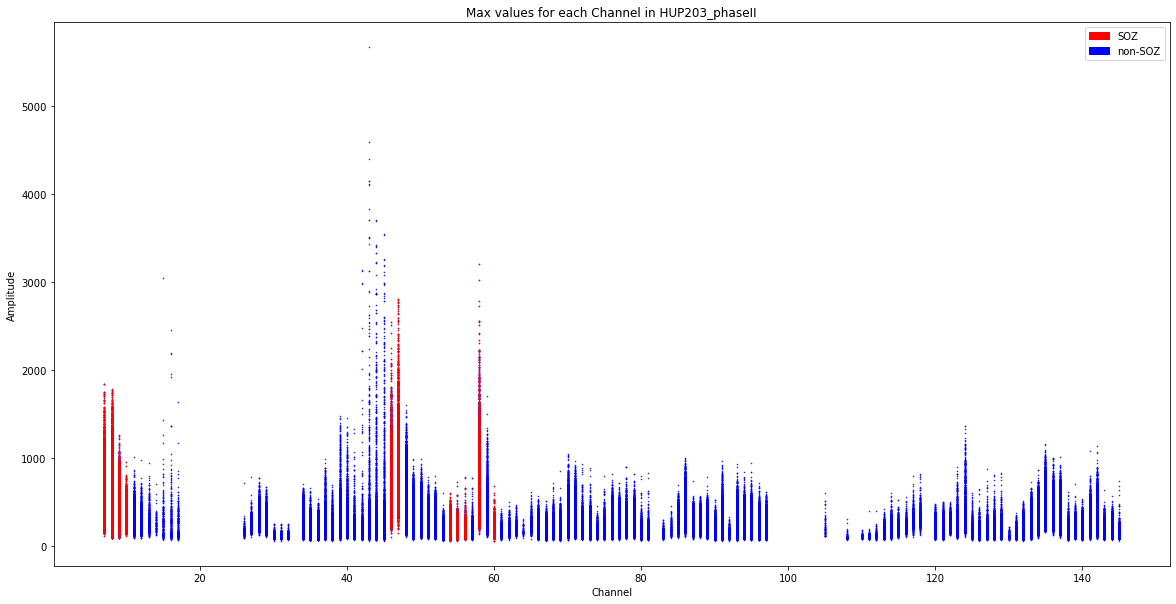

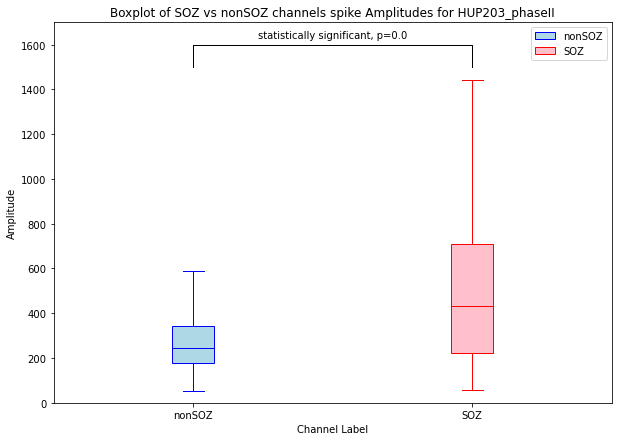

95.09976100000006


In [112]:
#takes about 136 seconds (2.5mins) per patient
import time
start = time.process_time()

#my code
pval, SOZ_all, nonSOZ_all = calc_maxes_and_stats('HUP203_phaseII',98)
print('pvalue for '+filename,' =', pval)
plot_scatter('HUP203_phaseII',98)
plot_box_per_pt('HUP203_phaseII',98)
#mycode

print(time.process_time() - start)

In [130]:
filenames = loadmat('/Users/carlosaguila/PycharmProjects/CNT_Interictal_Spikes/fname.mat');

In [212]:
whichPts = filenames['fname'][1]# list of WhichPts.
filenameX = filenames['fname'][0]#[0][0][X] - list of all filenames, then you add [0][0][which of the filenames in pt you want]


In [215]:
ALL_files = []
for i in range(len(filenameX)):
    for k in range(len(filenameX[i][0])):
        ALL_files.append([whichPts[i][0][0],filenameX[i][0][k][0]])

In [218]:
ALL_files

filename = []
whichPts = []

for i in range(len(ALL_files)):
    filename.append(ALL_files[i][1])
    whichPts.append(ALL_files[i][0])

In [224]:
with open("/Users/carlosaguila/PycharmProjects/CNT_Interictal_Spikes/pt_data/filename.pkl", "wb") as f:   #Pickling
    pickle.dump(filename, f)

with open("/Users/carlosaguila/PycharmProjects/CNT_Interictal_Spikes/pt_data/whichPts.pkl", "wb") as Q:   #Pickling
    pickle.dump(whichPts, Q)

In [225]:
with open("/Users/carlosaguila/PycharmProjects/CNT_Interictal_Spikes/pt_data/filename.pkl", "rb") as f:   #Unpickling
    filename = pickle.load(f)
    
with open("/Users/carlosaguila/PycharmProjects/CNT_Interictal_Spikes/pt_data/whichPts.pkl", "rb") as Q:   # Unpickling
    whichPts = pickle.load(Q)